This didn't work at all, but it's kind of interesting and maybe there's room to make it better...

Ideas:
  - Binary search for (x1, y1) then for (x2, y2). Have it estimate the relative location (0-1) of a line that is left of the object and a line that is above the object. Render the line, pass image back, ask which side of the line the object falls on

```txt
Hello! I would like you to help me localize an object in an image. Here is the object you must find:

**OBJECT: The first handwritten move in this chess notation sheet, for white's move 1**

This will be an iterative process: you will estimate the location of the bounding box, then I will render that bounding box onto the image as a red rectangle, and pass the new image back to you. When you think the bounding box correctly outlines the object, you will return "done": true as part of your JSON response. Otherwise, you will give me a list of deltas that describe how I should update the **most recent** coordinates of your bounding box estimate (and include "done": false"). We will repeat this until you decide that the bounding box tightly wraps the object you must localize. Your goal is to draw the correct bounding box in as few iterations as possible.

You will specify the bounding box as a 4-tuple: `(left, top, right, bottom)`. All four values should be **relative** values - numbers between 0 and 1 that are relative to the image width or height (for x and y respectively). By default, I will overlay green gridlines on the image, dividing it equally into 10 sections on both axes. This may help you estimate the relative location of the object, since these lines will fall exactly on 0.1, 0.2, ..., 0.9 times the width or height of the full image. You may also specify `"grid": false` in your JSON if you want to see the object you are localizing more clearly (ex. to verify you have completed the task).

From THIS POINT on, ALL further messages should be in **JSON format only**. Your responses are part of an image processing pipeline that relies on your entire response being ONLY JSON. Please respond with the initial response below to indicate you understand and are ready to continue. Thank you in advance for your help!

# Example responses
## Initial "ready" response
{
  "done": false,
}


## Initial bounding box estimate
{
  "done": false,
  "l": 0.xx,
  "t": 0.xx,
  "r": 0.xx,
  "b": 0.xx
}


## Subsequent bounding box estimate updates
{
  "done": false,
  "dl": 0.xx,
  "dt": 0.xx,
  "dr": 0.xx,
  "db": 0.xx
}


## Final response
{
  "done": true
}

```

In [ ]:
import cv2

img = cv2.imread("data/raw/0060.png")

In [ ]:
import cv2
from cv2.typing import MatLike
import matplotlib.pyplot as plt
import numpy as np


def draw_grid_on_image(
        img: MatLike,
        divisions=10,
        thickness_px=2
    ) -> MatLike:

    # Convert PIL image to OpenCV image
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    height, width = img.shape[:2]

    # Draw vertical lines
    for i in range(1, divisions):
        x = int(width / divisions * i)
        cv2.line(img, (x, 0), (x, height), (0, 200, 0), thickness_px)

    # Draw horizontal lines
    for i in range(1, divisions):
        y = int(height / divisions * i)
        cv2.line(img, (0, y), (width, y), (0, 200, 0), thickness_px)

    return img


def draw_bounding_box_on_image(
    img: MatLike,
    bbox: tuple[float, float, float, float]
) -> MatLike:
    # bbox is a tuple of (left, top, right, bottom) as relative values (between 0 and 1 relative to the image size)
    width, height = img.shape[:2]
    left, top, right, bottom = bbox
    x1, y1, x2, y2 = left * width, top * height, right * width, bottom * height
    width = x2 - x1
    height = y2 - y1

    # Draw the bounding box
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (200, 0, 0), 5)

    return img


def show_img(img: MatLike) -> None:
    # Display the image larger
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

bbox = (0.23000000000000004, 0.38, 0.23, 0.3799999999999999)


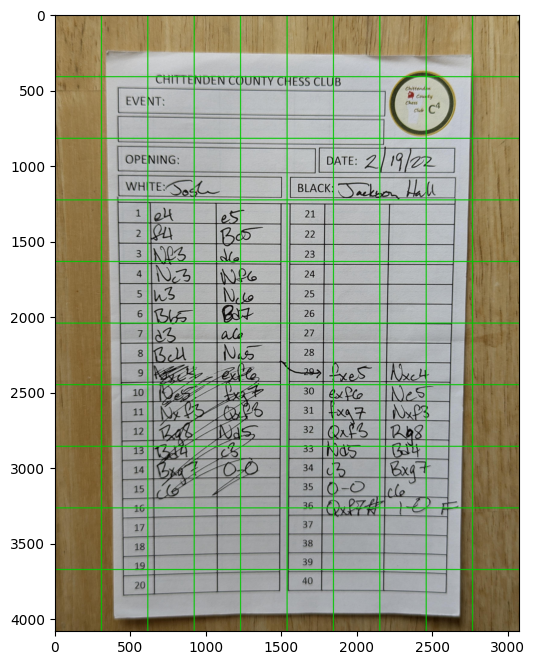

In [ ]:
import json
from cv2.typing import MatLike


# Paste the raw responses from ChatGPT here
responses = [
    """
{
  "done": false
}
""",
    """
{
  "done": false,
  "l": 0.05,
  "t": 0.12,
  "r": 0.15,
  "b": 0.18
}
""",
    """
{
  "done": false,
  "dl": 0.1,
  "dt": 0.05,
  "dr": 0.1,
  "db": 0.05
}
""",
    """{
  "done": false,
  "dl": 0.02,
  "dt": 0.35,
  "dr": -0.03,
  "db": 0.45
}
""",
    """{
  "done": false,
  "dl": 0.01,
  "dt": -0.16,
  "dr": 0.03,
  "db": -0.28
}
""",
    """{
  "done": false,
  "dl": 0.05,
  "dt": 0.02,
  "dr": -0.02,
  "db": -0.02
}
""",
]

def show_next_img(img: MatLike) -> None:
    show_grid = True
    bbox: tuple[float, float, float, float] = None
    for response in responses:
        response = json.loads(response)

        if "done" not in response:
            raise ValueError(f"Invalid response: {response}")
        elif response["done"]:
            break

        if "l" in response:
            assert all((k in response for k in ("t", "r", "b")))
            bbox = (response["l"], response["t"], response["r"], response["b"])
        elif "dl" in response:
            assert all((k in response for k in ("dt", "dr", "db")))
            assert bbox is not None

            l, t, r, b = bbox
            dl = response["dl"]
            dt = response["dt"]
            dr = response["dr"]
            db = response["db"]

            bbox = (l + dl, t + dt, r + dr, b + db)

        if "grid" in response:
            show_grid = response["grid"]
        
    next_img = img
    if show_grid:
        next_img = draw_grid_on_image(next_img, thickness_px=5)

    if bbox is not None:
        print(f'{bbox = }')
        next_img = draw_bounding_box_on_image(next_img, bbox)
    
    show_img(next_img)


show_next_img(img)